In [3]:
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split


In [4]:
import pandas as pd

df = pd.read_csv('train.csv')

X_train, X_test, y_train, y_test = train_test_split(df.text,df.target,test_size=0.7,random_state=42, shuffle=False)
X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]


(2283, 5330, 2283, 5330)

In [5]:
import numpy as np
import pandas as pd

# Assuming df is your DataFrame containing the tweets
# Create the vocabulary

vocabulary = np.array([])
for i in range(len(df.index)):
    words = df['text'].iloc[i].split()  
    vocabulary = np.append(vocabulary, np.unique(words))  
    vocabulary = np.unique(vocabulary)

# Create a dictionary to map each word to an index
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

# Function to one-hot encode a tweet
def one_hot_encode(tweet, vocab_size):
    one_hot_vector = np.zeros(vocab_size)
    for word in tweet.split():
        if word in word_to_index:
            index = word_to_index[word]
            one_hot_vector[index] = 1
    return one_hot_vector

# Apply the one-hot encoding to each tweet
one_hot_encoded_tweets = np.array([one_hot_encode(tweet, len(vocabulary)) for tweet in df['text']])

# Convert to DataFrame for better readability (optional)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_tweets, columns=vocabulary)
print(one_hot_encoded_df.columns)

Index(['!', '!!', '!!!', '!!!!', '!!!!!', '!!!!!!!!!!!#MetroFmTalk', '!The',
       '#', '##book', '##fukushima',
       ...
       'å£9!', 'å¤}', 'å¨', 'å©Daniel', 'å¬'Only', 'åÇ', 'åÈ',
       'åÈMGN-AFRICAå¨', 'åÊ', 'åÊFedEx'],
      dtype='object', length=31924)


In [6]:
n_letters = one_hot_encoded_df.shape[1]
n_letters

31924

In [7]:
one_hot_encoded_df.to_csv("one_hot_encoded_df.csv",index=True)

one_hot_encoded_df

,!,!!,!!!,!!!!,!!!!!,!!!!!!!!!!!#MetroFmTalk,!The,#,##book,##fukushima,...,å£9!,å¤},å¨,å©Daniel,å¬'Only,åÇ,åÈ,åÈMGN-AFRICAå¨,åÊ,åÊFedEx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def letterToIndex(letter):
    return one_hot_encoded_df.columns.get_loc(letter)

def lineToTensor(line):
    line = line.split()
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [83]:
criterion = nn.NLLLoss()
all_categories = [1,0]

rnn = torch.load('rnn1.pth')

n_correct = 0
for index, row in y_test.items():
    line_tensor = lineToTensor(X_test.loc[index])
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        category = torch.tensor([all_categories.index(y_test.iloc[i])], dtype=torch.long)
        output, hidden = rnn(line_tensor[i], hidden)
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        n_correct +=1

In [86]:
accuracy = n_correct/y_test.shape[0]
accuracy

0.5384615384615384

In [129]:
Hout = 100
from torch.autograd import Variable

class RNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.num_layers = 1
        self.RNNmodel = nn.RNN(input_size = Hin, hidden_size =Hout, num_layers=self.num_layers , batch_first = True, nonlinearity = 'relu' )
        self.linear = nn.Linear(in_features = Hout, out_features=Hin)
        self.softmax = nn.Softmax(dim= 0)

    def forward(self,x):
        # h0 = Variable(torch.zeros(self.num_layers, x.size(0), Hout))
        x = self.RNNmodel(x)
        x = self.linear(x)  
        x = self.softmax(x)
        return x


In [130]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden  = 128
n_letters = 31924
n_categories = 2

rnn = RNN(n_letters, n_hidden, n_categories)

In [131]:
all_categories = [1,0]

In [132]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()



In [133]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(df[df.target==category].index)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(df.text.iloc[line])
    return category, line, category_tensor, line_tensor

randomChoice(all_categories)

randomChoice(df[df.target==1].index)

randomTrainingExample()

(0,
 976,
 tensor([1]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]]]))

In [134]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (6m 49s) 0.6654 503 / 0 ✓
10000 10% (12m 54s) 0.5896 2700 / 0 ✓
15000 15% (19m 30s) 0.6480 2285 / 1 ✓
20000 20% (26m 57s) 0.7524 2484 / 1 ✗ (0)
25000 25% (33m 30s) 0.4954 4378 / 1 ✓
30000 30% (39m 49s) 0.7269 237 / 1 ✗ (0)
35000 35% (45m 39s) 1.0618 643 / 1 ✗ (0)
40000 40% (51m 22s) 0.8661 2425 / 1 ✗ (0)
45000 45% (57m 2s) 0.4274 3074 / 0 ✓
50000 50% (63m 2s) 0.1997 2308 / 0 ✓
55000 55% (68m 45s) 0.3469 3229 / 0 ✓
60000 60% (74m 28s) 0.3075 2079 / 0 ✓
65000 65% (80m 7s) 0.0081 3131 / 1 ✓
70000 70% (86m 16s) 0.0094 3773 / 0 ✓
75000 75% (93m 4s) 0.0172 4048 / 1 ✓
80000 80% (101m 2s) 0.9186 2919 / 1 ✗ (0)


In [98]:
rnn

RNN(
  (i2h): Linear(in_features=31924, out_features=128, bias=True)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

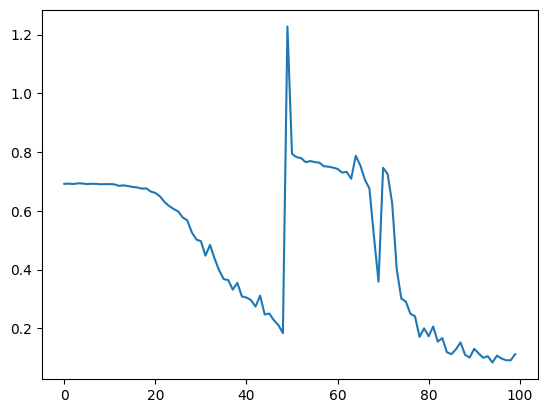

In [99]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [115]:

def randomTrainingExampleTest():
    category = randomChoice(all_categories)
    line = randomChoice(df_test[df_test.target==category].index)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(df_test.text.iloc[line])
    return category, line, category_tensor, line_tensor

randomTrainingExampleTest()

IndexError: single positional indexer is out-of-bounds